In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from evaluation import eval_utils as eu
from plugin.VidToMe.utils import save_video, load_video
from plugin.FastBlend.api import smooth_video
from utils.dataparsers import get_flowid
from utils.flow_utils import warp_flow, get_mask_bwds, compute_fwdbwd_mask

/tmp/ipykernel_67949/3973469072.py:21: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc
/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = "../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device)
elif config.data.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    config.data.rgb_path = os.path.join('../', config.data.rgb_path).replace('agirobot', 'agibot')  # update relative path for notebook
    data_parser = VideoDataParser(config.data, config.device)
    # data_parser.flow_model = 'raft'
else:
    raise NotImplementedError(f"Scene type {config.scene_type} is not supported.")

frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids, rgb_threshold=2/255)  

[INFO] frame indexes:  0 2 ... 438 440
[INFO] loaded video with 221 frames from: ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head.mp4
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


/data1/yang_liu/python_workspace/IC-Light/notebooks/../evaluation/eval_utils.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(cfg.restore_ckpt, map_lo

please consider installing flash attention for faster inference
MemFlowNet_skflow
no flash attention installed
[Using basicencoder as context encoder]
[Using basicencoder as feature encoder]
[Using GMA-SK2]
[Using corr_fn default]
[Loading ckpt from /data1/yang_liu/python_workspace/IC-Light/models/memflow/MemFlowNet_things.pth]
[INFO] Saving future flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_future_flow_memflow as .pt files
[INFO] Saving past flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_past_flow_memflow as .pt files


Loading Flows:   0%|          | 0/221 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers.py:584: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea

[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Assigning flow ids: 100%|██████████| 220/220 [00:00<00:00, 848.72it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 7513760 / 67891200


In [3]:
# save_video(org_frames, output_dir, save_frame=True, fps=15, gif=False, post_fix="_gt")

## 0. MemFlow

In [ ]:
# flows, past_flows, mask_bwds = data_parser.load_flow(frame_ids, future_flow=True, past_flow=True, gts=org_frames**0.5);
import os
import sys
import torch
import numpy as np

from plugin.MemFlow.core.Networks import build_network
from plugin.MemFlow.configs.things_memflownet import get_cfg
from plugin.MemFlow.inference import inference_core_skflow as inference_core
from plugin.MemFlow.core.utils.utils import InputPadder, forward_interpolate
from plugin.MemFlow.core.utils import frame_utils
from loguru import logger as loguru_logger

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cfg = get_cfg()
cfg.name = 'MemFlowNet'
cfg.stage = 'things'
cfg.warm_start = True
cfg.restore_ckpt = "../models/memflow/MemFlowNet_things.pth"
model = build_network(cfg).cuda()
loguru_logger.info("Parameter Count: %d" % count_parameters(model))

if cfg.restore_ckpt is not None:
    print("[Loading ckpt from {}]".format(cfg.restore_ckpt))
    ckpt = torch.load(cfg.restore_ckpt, map_location='cpu')
    ckpt_model = ckpt['model'] if 'model' in ckpt else ckpt
    if 'module' in list(ckpt_model.keys())[0]:
        for key in ckpt_model.keys():
            ckpt_model[key.replace('module.', '', 1)] = ckpt_model.pop(key)
        model.load_state_dict(ckpt_model, strict=True)
    else:
        model.load_state_dict(ckpt_model, strict=True)

model.eval()

processor = inference_core.InferenceCore(model, config=cfg)

images = org_frames.cuda().unsqueeze(0)

padder = InputPadder(images.shape)
images = padder.pad(images) * 2.0 - 1.0

with torch.no_grad():
    print(f"start inference...")

    flow_prev = None
    results_backward = []
    for ti in range(1, images.shape[1]):
        input = torch.cat([images[:, ti:ti+1], images[:, ti-1:ti]], dim=1)
        flow_low, flow_pre = processor.step(input, end=(ti == 0),
                                            add_pe=('rope' in cfg and cfg.rope), flow_init=flow_prev)
        flow_pre = padder.unpad(flow_pre[0]).cpu()
        results_backward.append(flow_pre)
        if 'warm_start' in cfg and cfg.warm_start:
            flow_prev = forward_interpolate(flow_low[0])[None].cuda()
    results_backward = [torch.zeros_like(results_backward[-1])] + results_backward

    flow_prev = None
    results_forward = []
    for ti in range(images.shape[1] - 1):
        input = images[:, ti:ti + 2]
        flow_low, flow_pre = processor.step(input, end=(ti == images.shape[1] - 2),
                                            add_pe=('rope' in cfg and cfg.rope), flow_init=flow_prev)
        flow_pre = padder.unpad(flow_pre[0]).cpu()
        results_forward.append(flow_pre)
        if 'warm_start' in cfg and cfg.warm_start:
            flow_prev = forward_interpolate(flow_low[0])[None].cuda()
    results_forward.append(torch.zeros_like(results_forward[-1]))

flows = torch.stack(results_forward).to(data_parser.device)
past_flows = torch.stack(results_backward).to(data_parser.device)
mask_bwds = get_mask_bwds(org_frames, flows, past_flows, alpha=data_parser.alpha)

In [26]:
mask_bwds = get_mask_bwds(org_frames, flows, past_flows, alpha=data_parser.alpha, dilate=True)

In [27]:
pil_list = eu.video_to_pil_list(f'{output_dir}/modified/exposure/frames')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0

In [41]:
flow_ids = get_flowid(org_frames, flows, mask_bwds, rgb_threshold=0.01).reshape(-1, 1)
# annotations = ((load_video(f"{output_dir}/Annotations", data_parser.h, data_parser.w) + 1) * 127).to(torch.long)
# idx_feature = torch.cat([flow_ids, annotations.permute(0, 2, 3, 1).reshape(-1, 3)], dim=-1)
idx_feature = flow_ids
_, unq_inv_t, _ = torch.unique(idx_feature, return_inverse=True, return_counts=True, dim=0)

Assigning flow ids: 100%|██████████| 220/220 [00:00<00:00, 661.53it/s]


In [8]:
from utils.RIFE.IFNet_HDv4 import IFNet
smooth_iteration = 1
smoothed_edited_images = edited_images
interpolater = IFNet(ckpt_path="../models/rife/flownet_v4.22.pkl").to(data_parser.device).eval()

for k in tqdm(range(smooth_iteration), desc="Frames Smoothing"):
    smoothed_edited_images_list = [smoothed_edited_images[0]]
    for i in range(1, len(edited_images)-1):
        s_frame = smoothed_edited_images[i-1:i]
        m_frame = smoothed_edited_images[i:i+1]
        e_frame = smoothed_edited_images[i+1:i+2]

        with torch.no_grad():
            interp_frames_s = interpolater.inference(s_frame, m_frame)
            interp_frames_e = interpolater.inference(m_frame, e_frame)
            interp_frames_m = interpolater.inference(interp_frames_s, interp_frames_e)

        smoothed_edited_images_list.append(interp_frames_m[0])
    smoothed_edited_images_list.append(smoothed_edited_images[-1])
    smoothed_edited_images = torch.stack(smoothed_edited_images_list, dim=0)

/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/RIFE/IFNet_HDv4.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(convert(torch.load(ck

In [42]:
frames = edited_images
N, _, H, W = frames.shape
feats_rgb = frames.permute(0, 2, 3, 1).reshape(-1, 3)
feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_t, dim=0, reduce='mean')
new_frames = feats_rgb[unq_inv_t].reshape(N, H, W, 3).permute(0, 3, 1, 2)

(-0.5, 639.5, 479.5, -0.5)

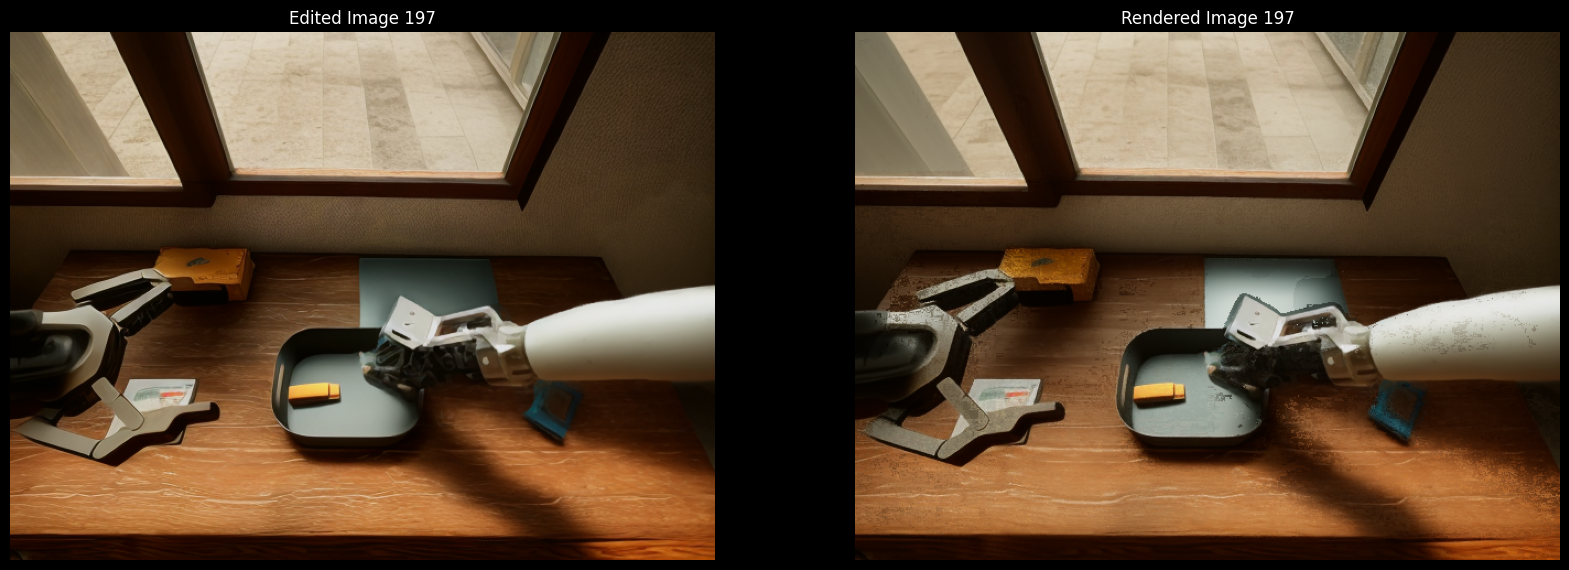

In [43]:
idx = random.randint(0, len(frame_ids) - 1)
idx = 197
rendered_img = new_frames[idx].cpu().numpy().transpose(1, 2, 0)
avg_img = torch.mean(frames[idx-1:idx+2], dim=0).cpu().numpy().transpose(1, 2, 0)
# annotation = annotations[idx].cpu().numpy().transpose(1, 2, 0)

import flow_vis
flow_color = flow_vis.flow_to_color(flows[idx].permute(1,2,0).cpu().numpy(), convert_to_bgr=False)

with torch.no_grad():
    mask_bwd = mask_bwds[idx:idx+1]
    # warped_image = warp_flow(frames[idx+1:idx+2], flows[idx:idx+1])
    warped_image = warp_flow(frames[idx-1:idx], past_flows[idx:idx+1])
    warped_image[~mask_bwd] = 0
    warped_image = warped_image.permute(0, 2, 3, 1).cpu().numpy()
    warped_image = np.clip(warped_image[0], 0, 1)

    pil_img = frames[idx:idx+1].clone()
    # pil_img[~mask_bwd] = 0
    pil_img = pil_img.permute(0, 2, 3, 1).cpu().numpy()
    pil_img = np.clip(pil_img[0], 0, 1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title(f'Edited Image {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_img)
plt.title(f'Rendered Image {idx}')
# plt.imshow(flow_color)
# plt.title(f'Flow {idx}')
# plt.imshow(mask_bwd[0, 0].cpu().numpy())
# plt.imshow(warped_image)
# plt.title(f'Warped Image {idx}')
plt.axis('off')

## 1. Optimizing Unique Tensor

In [35]:
import datetime
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, l2_loss, relaxed_ms_ssim, TVLoss
from utils.dataloader import OptDataset
from utils.RIFE.IFNet_HDv4 import IFNet

# vgg_loss = VGGPerceptualLoss(resize=False)
max_sh_degree = 3
lambda_dssim = 0.1
lambda_perceptual = 0.01
lambda_depth = 1.0
lambda_tv = 0.05
d_final_factor = 0.1
lambda_flow = 0.6
lambda_exp = 0.8
epochs_exposure = 35
epochs = 70
batch_size = 16
iterations = epochs_exposure * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0
tv_loss = TVLoss(lambda_tv)

In [36]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

dataset = OptDataset(
    edited_images,
    past_flows,
    mask_bwds,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

with torch.no_grad():
    # data_parser.unq_inv stablizes overall lighting
    pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    pil_tensor = torch_scatter.scatter(pil_tensor, unq_inv_t, dim=0, reduce='mean')

    # prepare per-image confidence weights
    # loss_weight = relaxed_ms_ssim(org_frames, dataset.edited_images, data_range=1, start_level=1, size_average=False)
    # loss_weight = loss_weight / loss_weight.sum() * len(loss_weight)  # normalize to sum to N

fused_color = RGB2SH(pil_tensor)
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

loss_list = []

pbar = tqdm(total=epochs, desc="Optimizing Unique Tensor")

for epoch in range(epochs):
    for i, (idxs, _edited_images, _, _past_flows, _mask_bwds) in enumerate(data_loader):

        step = epoch * len(frame_ids) // batch_size + i + 1
        _mask_bwds = _mask_bwds[idxs>0]
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        unq_inv = unq_inv_t.reshape(N, H, W, -1)[cat_idxs].reshape(-1)
        cat_images = SH2RGB(features_dc)[unq_inv].reshape(len(cat_idxs), H*W, -1) # N x HW x 3
        # cat_images = SH2RGB(features_dc).reshape(N, H, W, -1)[cat_idxs]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(len(cat_idxs), H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        warped_images = warp_flow(pre_images, _past_flows)
        warped_images_m = warped_images[idxs>0]
        images_m = images[idxs>0]
        warped_images_m = warped_images_m * _mask_bwds.float()
        images_m = images_m * _mask_bwds.float()

        # plt.style.use("seaborn-v0_8-whitegrid")
        # plt.figure(figsize=(16, 10))
        # plt.subplot(1, 2, 1)
        # plt.imshow(images_m[0].permute(1, 2, 0).detach().cpu().numpy())
        # plt.title(f"Rendered RGB of Frame {idxs[0]}")
        # plt.axis("off")

        # plt.subplot(1, 2, 2)
        # plt.imshow(warped_images_m[0].permute(1, 2, 0).detach().cpu().numpy())
        # plt.title(f"Warped of Frame {idxs[0]}")
        # plt.axis("off")
        # break
        
        # loss_flow = l1_loss(images_m, warped_images_m)
        loss_flow = (1.0 - relaxed_ms_ssim(images_m, warped_images_m, data_range=1, start_level=1)) * lambda_dssim + \
                    l1_loss(images_m, warped_images_m) * (1 - lambda_dssim)

        loss_tv = tv_loss(images)
        
        # 0. original
        loss_photometric = (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim

        loss = (1 - lambda_flow) * loss_photometric + lambda_flow * loss_flow + loss_tv

        loss_list.append([loss.item(), loss_photometric.item(), loss_flow.item()])

        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

images = SH2RGB(features_dc)[unq_inv_t].reshape(N, H*W, -1) # N x HW x 3
# images = SH2RGB(features_dc).reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

Optimizing Unique Tensor: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s, loss=0.001008, loss_flow=-0.000147, loss_photometric=0.002428]

Memory: 7527.90 MB
Time: 54.866699s


In [37]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
# smoothed_edited_images_np = smoothed_edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_frames.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 639.5, 479.5, -0.5)

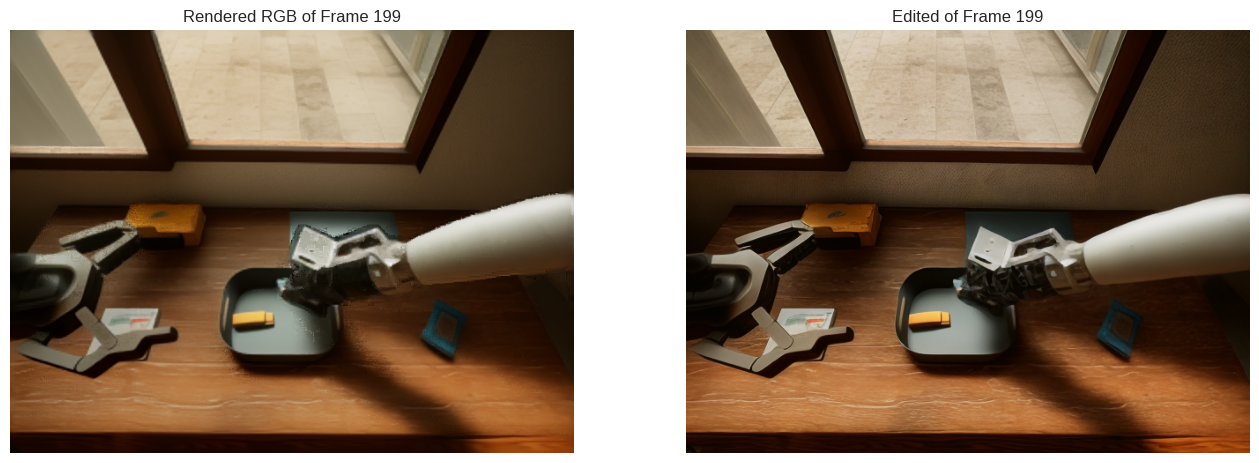

In [38]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
idx = 199

# with torch.no_grad():
#     mask_bwd = dataset.mask_bwd[idx:idx+1]
#     warped_images = warp_flow(images[idx-1:idx], dataset.past_flows[idx:idx+1])
#     warped_images[~mask_bwd] = 0
#     warped_images = warped_images.permute(0, 2, 3, 1).cpu().numpy()
#     warped_images = np.clip(warped_images[0], 0, 1)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
# plt.imshow(warped_images)
# plt.title(f"Warped of Frame {idx}")
plt.axis("off")

In [18]:
cur_output_path = f'{output_dir}/modified/exposure/memflow_opt_wo_seg_warm_t'
save_video(images, cur_output_path, save_frame=True, fps=15)
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/modified/exposure/memflow_opt_wo_seg_warm_t/output.gif


0